In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Dense

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

#### Importing data

In [2]:
train_df = pd.read_csv('training.csv')
train_orig_df = train_df.copy()
train_df.head()

,id,posted_time,updated_time,age,updated_age,app_type,owner_id,owner_type,owner_influence,number_of_likes,...,participant5_id,participant5_action,participant5_gender,participant5_is_employee,participant5_is_lead,participant5_is_in_connections,participant5_focus,participant5_order,participant5_influence,rank
0,175339,1.514050e+12,1.514050e+12,6.315242e+10,6.315242e+10,other,57727,space,0.99973,1,...,3089,viewed,male,0,0,1,other,1,0.23077,0.73677
1,175348,1.514110e+12,1.515160e+12,6.309278e+10,6.204696e+10,forum,111913,space,0.99977,0,...,44661,viewed,male,0,0,1,other,1,0.23077,0.78240
2,175353,1.514120e+12,1.515160e+12,6.309049e+10,6.204716e+10,forum,111913,space,0.99977,0,...,3080,viewed,male,0,0,1,marketing,1,0.23077,0.82125
3,175371,1.514190e+12,1.514190e+12,6.301324e+10,6.301324e+10,other,9037,space,0.99949,0,...,3084,viewed,male,0,0,1,marketing,1,0.23077,0.61522
4,175372,1.514190e+12,1.514190e+12,6.301323e+10,6.301323e+10,other,9037,space,0.99949,0,...,3084,viewed,male,0,0,1,marketing,1,0.23077,0.61522


#### Preprocessing Step

In [3]:
# Get rid of redundant columns
redundant_cols = ['poster_is_employee', 'poster_is_lead', 'poster_order',
                  'participant1_is_lead', 'participant1_order',
                  'participant2_is_lead', 'participant2_order',
                  'participant3_is_lead', 'participant3_order',
                  'participant4_is_lead', 'participant4_order',
                  'participant5_is_lead', 'participant5_order',
                  'id', 'participant1_id', 'participant2_id', 'participant3_id',
                  'participant4_id', 'participant5_id', 'owner_id', 'poster_id',
                  'posted_time', 'updated_time', 'age', 'updated_age']
useful_cols = [i for i in train_df.columns if i not in redundant_cols]

train_df = train_df[useful_cols]

In [4]:
all_cols = [col for col in train_df.columns]
num_cols = [col for col in all_cols if train_df[col].dtype in ['int64', 'float64']]
cat_cols = [col for col in all_cols if col not in num_cols]

print("Amount of number columns: {}".format(len(num_cols)))
print("Amount of categorical columns: {}".format(len(cat_cols)))

Amount of number columns: 28
Amount of categorical columns: 19


In [5]:
encoder = OneHotEncoder(handle_unknown='ignore')

encoder.fit(train_df[cat_cols].to_numpy())
rez = encoder.transform(train_df[cat_cols].to_numpy())
rez_df = pd.DataFrame(rez.toarray())
    
rez_df.index = train_df.index

new_feature_names = encoder.get_feature_names(cat_cols)
rename_to_new = {old: new for old, new in zip(list(range(len(new_feature_names))), new_feature_names)}
rez_df = rez_df.rename(rename_to_new, axis=1)

train_enc_df = train_df.copy()
train_enc_df = train_enc_df.merge(rez_df, right_index=True, left_index=True, how='outer')
train_enc_df = train_enc_df.drop(cat_cols, axis=1)

print('Shape of encoded dataframe -> {}'.format(train_enc_df.shape))
train_enc_df.head()

Shape of encoded dataframe -> (9418, 88)


,owner_influence,number_of_likes,number_of_comments,reactivity,is_mentions_me,is_mentions_connections,is_commented_by_me,is_commented_by_connections,is_liked_by_me,is_liked_by_connections,...,participant4_focus_sales,participant5_action_commented,participant5_action_liked,participant5_action_viewed,participant5_gender_female,participant5_gender_male,participant5_focus_engineering,participant5_focus_marketing,participant5_focus_other,participant5_focus_sales
0,0.99973,1,0,1.00000,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.99977,0,2,0.12336,0,0,0,1,0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.99977,0,3,0.12336,0,0,0,1,0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.99949,0,0,0.00000,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.99949,0,0,0.00000,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [6]:
# Normalization

x = train_enc_df.values  # returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

norm_df = pd.DataFrame(x_scaled)
norm_df.index = train_enc_df.index
rename_to_new = {old: new for old, new in zip(list(range(norm_df.shape[1])), train_enc_df.columns)}
norm_df = norm_df.rename(rename_to_new, axis=1)

norm_df.head()

,owner_influence,number_of_likes,number_of_comments,reactivity,is_mentions_me,is_mentions_connections,is_commented_by_me,is_commented_by_connections,is_liked_by_me,is_liked_by_connections,...,participant4_focus_sales,participant5_action_commented,participant5_action_liked,participant5_action_viewed,participant5_gender_female,participant5_gender_male,participant5_focus_engineering,participant5_focus_marketing,participant5_focus_other,participant5_focus_sales
0,0.999789,0.015625,0.000000,1.00000,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.999833,0.000000,0.013793,0.12336,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.999833,0.000000,0.020690,0.12336,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.999522,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.999522,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [7]:
X_train, X_valid = train_test_split(norm_df, train_size=0.85, shuffle=True, random_state=1)

print('Shape of X_train = {}'.format(X_train.shape))
print('Shape of X_valid = {}'.format(X_valid.shape))

Shape of X_train = (8005, 88)
Shape of X_valid = (1413, 88)


#### Building autoencoder

##### Deep Autoencoder

In [8]:
autoencoder = Sequential()
autoencoder.add(Dense(128, activation='relu', input_shape=(88,)))
autoencoder.add(Dense(64, activation='relu'))
autoencoder.add(Dense(32, activation='linear', name='bottleneck'))
autoencoder.add(Dense(64, activation='relu'))
autoencoder.add(Dense(128, activation='relu'))
autoencoder.add(Dense(88, activation='sigmoid'))

In [9]:
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_valid, X_valid))

Epoch 1/100
32/32 [==============================] - 0s 11ms/step - loss: 0.1651 - val_loss: 0.1075
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0914 - val_loss: 0.0739
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0645 - val_loss: 0.0564
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0528 - val_loss: 0.0485
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0456 - val_loss: 0.0425
Epoch 6/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0402 - val_loss: 0.0381
Epoch 7/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0355 - val_loss: 0.0341
Epoch 8/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0316 - val_loss: 0.0305
Epoch 9/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0288 - val_loss: 0.0280
Epoch 10/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0264 - val_loss: 0.0256
Epoch 11

32/32 [==============================] - 0s 5ms/step - loss: 0.0043 - val_loss: 0.0052
Epoch 84/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0043 - val_loss: 0.0054
Epoch 85/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0043 - val_loss: 0.0053
Epoch 86/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0042 - val_loss: 0.0052
Epoch 87/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0042 - val_loss: 0.0051
Epoch 88/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0041 - val_loss: 0.0051
Epoch 89/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0041 - val_loss: 0.0051
Epoch 90/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0041 - val_loss: 0.0050
Epoch 91/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0040 - val_loss: 0.0050
Epoch 92/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0040 - val_loss: 0.0049
Epoch 93/100


In [10]:
encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
encoded_data = encoder.predict(X_train)  # bottleneck representation
decoded_output = autoencoder.predict(X_train)        # reconstruction
encoding_dim = 32

# return the decoder
encoded_input = Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-3](encoded_input)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(encoded_input, decoder)

##### Experiments with bottleneck layer

In [11]:
loss = []
N = 88

for N_hidden in range(5, N, 5):
    # Building network, where bottleneck has N_hidden number of neurons
    autoencoder = Sequential()
    autoencoder.add(Dense(128, activation='relu', input_shape=(N,)))
    autoencoder.add(Dense(64, activation='relu'))
    autoencoder.add(Dense(N_hidden, activation='linear', name='bottleneck'))
    autoencoder.add(Dense(64, activation='relu'))
    autoencoder.add(Dense(128, activation='relu'))
    autoencoder.add(Dense(N, activation='sigmoid'))

    autoencoder.compile(optimizer='adam', loss='mse')  # using standart params for autoencoder

    # Training
    history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=256, shuffle=True,
                    validation_data=(X_valid, X_valid), verbose=0)
    
    loss.append(history.history['val_loss'][-1])  # adding final validation loss to list

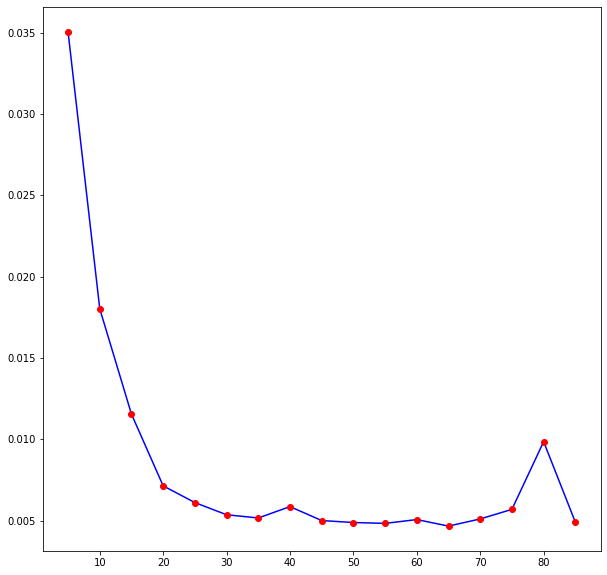

In [12]:
plt.figure(figsize=(10, 10))
plt.plot(range(5, N, 5), loss, color='blue')
plt.plot(range(5, N, 5), loss, 'ro')

We see that it is best to use n_hidden in [20, 40] range. We will choose n_hidden = 32 for this type of autoencoder.

##### Sparse Autoconder

In [13]:
autoencoder = Sequential()
autoencoder.add(Dense(128, activation='relu', input_shape=(88,)))
autoencoder.add(Dense(64, activation='relu'))
autoencoder.add(Dense(35, activation='linear', name='bottleneck', activity_regularizer=keras.regularizers.l1(1e-5)))  # adding regularizer
autoencoder.add(Dense(64, activation='relu'))
autoencoder.add(Dense(128, activation='relu'))
autoencoder.add(Dense(88, activation='sigmoid'))

In [14]:
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_valid, X_valid))

Epoch 1/100
32/32 [==============================] - 0s 7ms/step - loss: 0.1650 - val_loss: 0.1055
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0905 - val_loss: 0.0738
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0658 - val_loss: 0.0571
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0522 - val_loss: 0.0468
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0432 - val_loss: 0.0393
Epoch 6/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0365 - val_loss: 0.0334
Epoch 7/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0313 - val_loss: 0.0295
Epoch 8/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0273 - val_loss: 0.0259
Epoch 9/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0242 - val_loss: 0.0231
Epoch 10/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0218 - val_loss: 0.0210
Epoch 11/

32/32 [==============================] - 0s 5ms/step - loss: 0.0035 - val_loss: 0.0044
Epoch 84/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0035 - val_loss: 0.0043
Epoch 85/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0035 - val_loss: 0.0043
Epoch 86/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0035 - val_loss: 0.0043
Epoch 87/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0043
Epoch 88/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0043
Epoch 89/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0042
Epoch 90/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0033 - val_loss: 0.0042
Epoch 91/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0033 - val_loss: 0.0042
Epoch 92/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0033 - val_loss: 0.0041
Epoch 93/100


In [15]:
encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
encoded_data = encoder.predict(X_train)  # bottleneck representation
decoded_output = autoencoder.predict(X_train)        # reconstruction
encoding_dim = 35

# return the decoder
encoded_input = Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-3](encoded_input)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(encoded_input, decoder)

##### Experiments with bottleneck layer

In [16]:
loss = []
N = 88

for N_hidden in range(5, N, 5):
    # Building network, where bottleneck has N_hidden number of neurons
    autoencoder = Sequential()
    autoencoder.add(Dense(128, activation='relu', input_shape=(N,)))
    autoencoder.add(Dense(64, activation='relu'))
    autoencoder.add(Dense(N_hidden, activation='linear', name='bottleneck', activity_regularizer=keras.regularizers.l1(1e-5)))
    autoencoder.add(Dense(64, activation='relu'))
    autoencoder.add(Dense(128, activation='relu'))
    autoencoder.add(Dense(N, activation='sigmoid'))

    autoencoder.compile(optimizer='adam', loss='mse')  # using standart params for autoencoder

    # Training
    history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=256, shuffle=True,
                    validation_data=(X_valid, X_valid), verbose=0)
    
    loss.append(history.history['val_loss'][-1])  # adding final validation loss to list

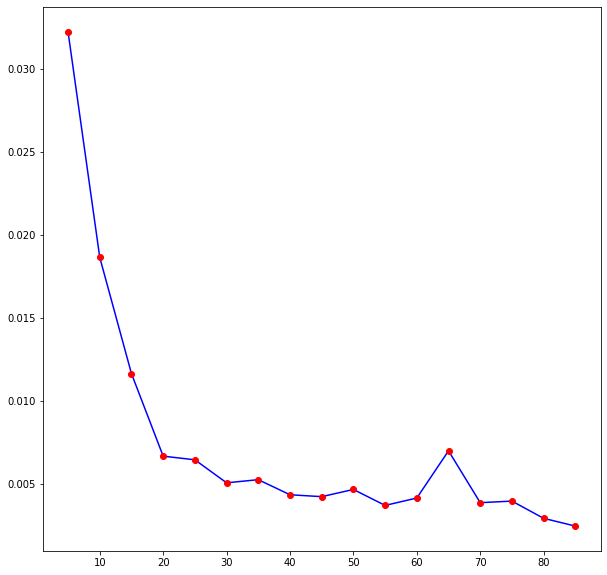

In [17]:
plt.figure(figsize=(10, 10))
plt.plot(range(5, N, 5), loss, color='blue')
plt.plot(range(5, N, 5), loss, 'ro')

We see that it is best to use n_hidden in [25, 45] range. We will choose n_hidden = 35 for this type of autoencoder.

##### Denoising autoencoder

In [18]:
# Creating noise data
noise_factor = 0.3
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) - noise_factor / 2
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_valid_noisy = X_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_valid.shape) - noise_factor / 2
X_valid_noisy = np.clip(X_valid_noisy, 0., 1.)

In [19]:
autoencoder = Sequential()
autoencoder.add(Dense(128, activation='relu', input_shape=(88,)))
autoencoder.add(Dense(64, activation='relu'))
autoencoder.add(Dense(35, activation='linear', name='bottleneck'))  # adding regularizer
autoencoder.add(Dense(64, activation='relu'))
autoencoder.add(Dense(128, activation='relu'))
autoencoder.add(Dense(88, activation='sigmoid'))

In [20]:
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(X_train_noisy, X_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_valid_noisy, X_valid))

Epoch 1/100
32/32 [==============================] - 0s 7ms/step - loss: 0.1718 - val_loss: 0.1213
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 0.1012 - val_loss: 0.0839
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0776 - val_loss: 0.0700
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0664 - val_loss: 0.0603
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0569 - val_loss: 0.0524
Epoch 6/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0508 - val_loss: 0.0483
Epoch 7/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0474 - val_loss: 0.0452
Epoch 8/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0446 - val_loss: 0.0427
Epoch 9/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0415 - val_loss: 0.0402
Epoch 10/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0390 - val_loss: 0.0380
Epoch 11/

32/32 [==============================] - 0s 6ms/step - loss: 0.0121 - val_loss: 0.0165
Epoch 84/100
32/32 [==============================] - 0s 4ms/step - loss: 0.0123 - val_loss: 0.0159
Epoch 85/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0121 - val_loss: 0.0156
Epoch 86/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0119 - val_loss: 0.0157
Epoch 87/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0119 - val_loss: 0.0153
Epoch 88/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0118 - val_loss: 0.0156
Epoch 89/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0118 - val_loss: 0.0156
Epoch 90/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0117 - val_loss: 0.0154
Epoch 91/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0116 - val_loss: 0.0154
Epoch 92/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0115 - val_loss: 0.0153
Epoch 93/100


In [21]:
encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
encoded_data = encoder.predict(X_train)  # bottleneck representation
decoded_output = autoencoder.predict(X_train)        # reconstruction
encoding_dim = 35

# return the decoder
encoded_input = Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-3](encoded_input)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(encoded_input, decoder)

##### Experiments with bottleneck layer

In [22]:
loss = []
N = 88

for N_hidden in range(5, N, 5):
    # Building network, where bottleneck has N_hidden number of neurons
    autoencoder = Sequential()
    autoencoder.add(Dense(128, activation='relu', input_shape=(N,)))
    autoencoder.add(Dense(64, activation='relu'))
    autoencoder.add(Dense(N_hidden, activation='linear', name='bottleneck'))
    autoencoder.add(Dense(64, activation='relu'))
    autoencoder.add(Dense(128, activation='relu'))
    autoencoder.add(Dense(N, activation='sigmoid'))

    autoencoder.compile(optimizer='adam', loss='mse')  # using standart params for autoencoder

    # Training
    history = autoencoder.fit(X_train_noisy, X_train, epochs=100, batch_size=256, shuffle=True,
                    validation_data=(X_valid_noisy, X_valid), verbose=0)
    
    loss.append(history.history['val_loss'][-1])  # adding final validation loss to list

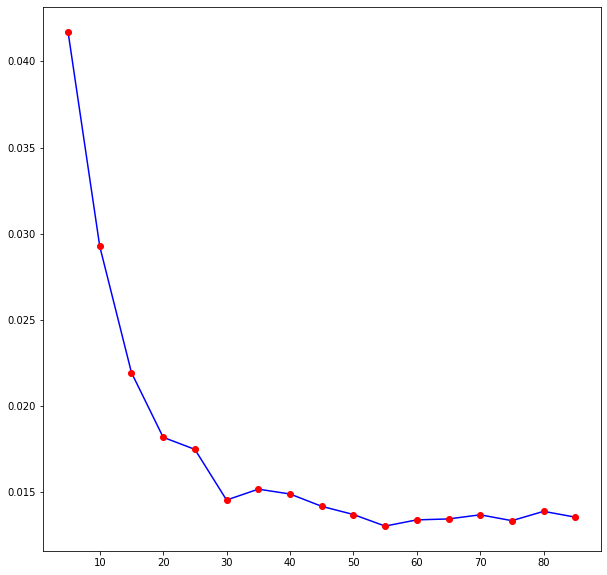

In [23]:
plt.figure(figsize=(10, 10))
plt.plot(range(5, N, 5), loss, color='blue')
plt.plot(range(5, N, 5), loss, 'ro')

We see that it is best to use n_hidden in [30, 40] range. We will choose n_hidden = 35 for this type of autoencoder.

##### Contractive Autoencoder

In [24]:
tf.compat.v1.disable_eager_execution()

autoencoder = Sequential()
autoencoder.add(Dense(128, activation='relu', input_shape=(88,)))
autoencoder.add(Dense(64, activation='relu'))
autoencoder.add(Dense(30, activation='linear', name='bottleneck'))
autoencoder.add(Dense(64, activation='relu'))
autoencoder.add(Dense(128, activation='relu'))
autoencoder.add(Dense(88, activation='sigmoid'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [25]:
def contractive_loss(y_pred, y_true, lam=1e-4):
    import tensorflow.keras.backend as K
    
    mse = K.mean(K.square(y_true - y_pred), axis=1)

    W = K.variable(value=autoencoder.get_layer('bottleneck').get_weights()[0])  # N x N_hidden
    W = K.transpose(W)  # N_hidden x N
    h = autoencoder.get_layer('bottleneck').output
    dh = h * (1 - h)  # N_batch x N_hidden

    # N_batch x N_hidden * N_hidden x 1 = N_batch x 1
    contractive = lam * K.sum(dh**2 * K.sum(W**2, axis=1), axis=1)

    return mse + contractive

In [26]:
autoencoder.compile(optimizer='adam', loss=contractive_loss, metrics=['mse'])

autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_valid, X_valid))

Train on 8005 samples, validate on 1413 samples
Epoch 1/100
8005/8005 [==============================] - 0s 20us/sample - loss: 0.1652 - mse: 0.1611 - val_loss: 0.1114 - val_mse: 0.1084
Epoch 2/100
8005/8005 [==============================] - 0s 17us/sample - loss: 0.0965 - mse: 0.0941 - val_loss: 0.0808 - val_mse: 0.0785
Epoch 3/100
8005/8005 [==============================] - 0s 16us/sample - loss: 0.0731 - mse: 0.0710 - val_loss: 0.0637 - val_mse: 0.0619
Epoch 4/100
8005/8005 [==============================] - 0s 17us/sample - loss: 0.0586 - mse: 0.0568 - val_loss: 0.0517 - val_mse: 0.0498
Epoch 5/100
8005/8005 [==============================] - 0s 17us/sample - loss: 0.0478 - mse: 0.0460 - val_loss: 0.0433 - val_mse: 0.0416
Epoch 6/100
8005/8005 [==============================] - 0s 19us/sample - loss: 0.0406 - mse: 0.0389 - val_loss: 0.0373 - val_mse: 0.0357
Epoch 7/100
8005/8005 [==============================] - 0s 17us/sample - loss: 0.0351 - mse: 0.0335 - val_loss: 0.0324 - va

In [27]:
encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
encoded_data = encoder.predict(X_train)  # bottleneck representation
decoded_output = autoencoder.predict(X_train)        # reconstruction
encoding_dim = 30

# return the decoder
encoded_input = Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-3](encoded_input)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(encoded_input, decoder)

##### Experimenting with bottleneck layer

In [28]:
loss = []
N = 88

for N_hidden in range(5, N, 5):
    # Building network, where bottleneck has N_hidden number of neurons
    autoencoder = Sequential()
    autoencoder.add(Dense(128, activation='relu', input_shape=(N,)))
    autoencoder.add(Dense(64, activation='relu'))
    autoencoder.add(Dense(N_hidden, activation='linear', name='bottleneck'))
    autoencoder.add(Dense(64, activation='relu'))
    autoencoder.add(Dense(128, activation='relu'))
    autoencoder.add(Dense(N, activation='sigmoid'))

    autoencoder.compile(optimizer='adam', loss=contractive_loss, metrics=['mse'])  # using standart params for autoencoder

    # Training
    history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=256, shuffle=True,
                    validation_data=(X_valid, X_valid), verbose=0)
    
    loss.append(history.history['val_loss'][-1])  # adding final validation loss to list

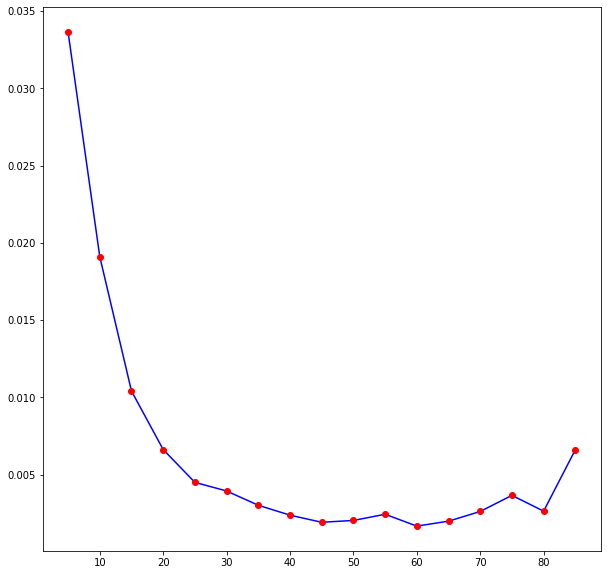

In [29]:
plt.figure(figsize=(10, 10))
plt.plot(range(5, N, 5), loss, color='blue')
plt.plot(range(5, N, 5), loss, 'ro')

We see that it is best to use n_hidden in [25, 35] range. We will choose n_hidden = 30 for this type of autoencoder.

#### Testing and checking results

In [30]:
example = X_valid.iloc[0].to_numpy().reshape(-1, 88)
lat_vec = encoder.predict(example)
print("We got latent vector of representation with the shape of {}.".format(lat_vec.shape))
print(lat_vec)

We got latent vector of representation with the shape of (1, 30).
[[ 0.8661361   0.4435926   1.5469556   1.1953349   0.5928811   0.9041688
   0.1161426   1.2647319   0.68115014  0.3408784   0.40820774  0.91105384
   0.2789299   0.06192778 -0.17348063  0.6097932   0.49193382  0.5943116
   1.3563703  -0.50361073 -0.63263327 -0.31563166  1.2749151  -0.0277421
   0.64152735  0.28510323  1.3123038   0.43368682  0.5748027   1.1408417 ]]


In [31]:
np.set_printoptions(precision=3, suppress=True)  # easier to read

reconstructed = decoder.predict(lat_vec)
print("Original example from which we got latent vector:")
print(example)
print("\nReconstructed representation from latent vector:")
print(reconstructed)
print("\nMatrix of absolute diferences between 1st and 2nd matrix:")
print(np.sqrt((example - reconstructed) ** 2))

Original example from which we got latent vector:
[[1.    0.469 0.034 1.    0.    0.    0.    1.    0.    1.    0.    0.995
  1.    1.    1.    1.    1.    0.999 1.    1.    0.998 0.    1.    0.996
  1.    0.    0.995 0.973 0.    0.    1.    0.    0.    0.    1.    0.
  1.    0.    0.    0.    0.    1.    0.    1.    0.    0.    0.    1.
  0.    1.    0.    0.    1.    0.    0.    0.    1.    0.    1.    0.
  0.    1.    0.    0.    0.    1.    0.    1.    0.    0.    1.    0.
  0.    0.    1.    0.    0.    1.    0.    1.    0.    0.    1.    0.
  0.    0.    1.    0.   ]]

Reconstructed representation from latent vector:
[[1.    0.229 0.04  0.975 0.    0.261 0.    1.    0.    0.999 0.    1.
  1.    0.989 1.    0.993 1.    0.999 0.989 0.963 0.991 0.031 0.947 1.
  1.    0.005 0.998 0.975 0.    0.    1.    0.    0.    0.    1.    0.
  0.999 0.002 0.    0.017 0.    0.996 0.    1.    0.    0.    0.187 0.728
  0.    0.999 0.    0.    1.    0.    0.    0.002 0.998 0.    0.999 0.
  0.    1. 